In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt 

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT

from HQA import HQA, HQA_variation

from utils import *
import os

In [4]:
# Architecture parameters

virtual_qubits = 128
qubits_per_core = 36
comm_qubits_per_link = np.arange(1, 11)
# QCores = 4 # This will depend on the virtual qubits and the available qubits for computation in the cores (which also depends on the quantum network)
single_qubit_gate_time = 7.9e-9
two_qubit_gate_time = 30e-9
meas_time = 40e-9
EPR_time = 130e-9
single_qubit_gate_error = 7.42e-5
two_qubit_gate_error = 7e-4
meas_error = 1.67e-4
# meas_error = 0 # TODO
EPR_error = 9e-3
# EPR_error = 0 # TODO
T1 = 1.2e-3
T2 = 1.16e-3
link_width = 15
proc_cycles = 2
clk_freq = 500e6


error_delta = 20
time_delta = 20

single_qubit_gate_time = single_qubit_gate_time/time_delta
two_qubit_gate_time = two_qubit_gate_time/time_delta
meas_time = meas_time/time_delta
EPR_time = EPR_time/time_delta
single_qubit_gate_error = single_qubit_gate_error/error_delta
two_qubit_gate_error = two_qubit_gate_error/error_delta
meas_error = meas_error/error_delta
EPR_error = EPR_error/error_delta
T1 = T1*time_delta
T2 = T2*time_delta

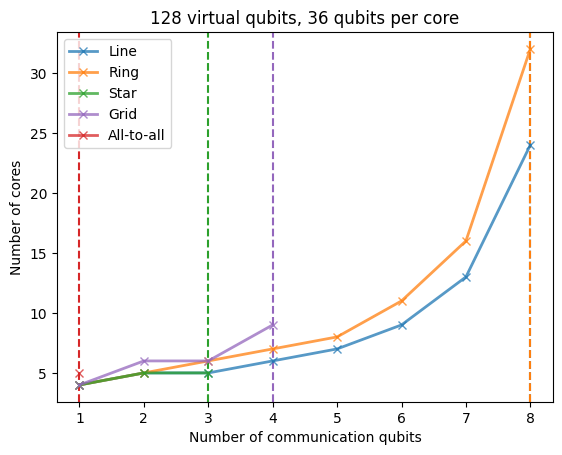

In [5]:
# Explore feasible configurations

line_capacities = [get_line_cores(virtual_qubits, comm_qubits, qubits_per_core) for comm_qubits in comm_qubits_per_link if get_line_cores(virtual_qubits, comm_qubits, qubits_per_core) != -1]
ring_capacities = [get_ring_cores(virtual_qubits, comm_qubits, qubits_per_core) for comm_qubits in comm_qubits_per_link if get_ring_cores(virtual_qubits, comm_qubits, qubits_per_core) != -1]
star_capacities = [get_star_cores(virtual_qubits, comm_qubits, qubits_per_core) for comm_qubits in comm_qubits_per_link if get_star_cores(virtual_qubits, comm_qubits, qubits_per_core) != -1]
grid_capacities = [get_grid_cores(virtual_qubits, comm_qubits, qubits_per_core) for comm_qubits in comm_qubits_per_link if get_grid_cores(virtual_qubits, comm_qubits, qubits_per_core) != -1]
all_to_all_capacities = [get_all_to_all_cores(virtual_qubits, comm_qubits, qubits_per_core) for comm_qubits in comm_qubits_per_link if get_all_to_all_cores(virtual_qubits, comm_qubits, qubits_per_core) != -1]

plt.plot(comm_qubits_per_link[:len(line_capacities)], [len(cores) for cores in line_capacities], label="Line", marker='x', alpha=0.75, linewidth=2, color='tab:blue')
plt.plot(comm_qubits_per_link[:len(ring_capacities)], [len(cores) for cores in ring_capacities], label="Ring", marker='x', alpha=0.75, linewidth=2, color='tab:orange')
plt.plot(comm_qubits_per_link[:len(star_capacities)], [len(cores) for cores in star_capacities], label="Star", marker='x', alpha=0.75, linewidth=2, color='tab:green')
plt.plot(comm_qubits_per_link[:len(grid_capacities)], [len(cores) for cores in grid_capacities], label="Grid", marker='x', alpha=0.75, linewidth=2, color='tab:purple')
plt.plot(comm_qubits_per_link[:len(all_to_all_capacities)], [len(cores) for cores in all_to_all_capacities], label="All-to-all", marker='x', alpha=0.75, linewidth=2, color='tab:red')

if len(line_capacities) < len(comm_qubits_per_link) and len(line_capacities) > 0:
    plt.axvline(comm_qubits_per_link[len(line_capacities)-1], color='tab:blue', linestyle='--', zorder=-1)

if len(ring_capacities) < len(comm_qubits_per_link) and len(ring_capacities) > 0:
    plt.axvline(comm_qubits_per_link[len(ring_capacities)-1], color='tab:orange', linestyle='--', zorder=-1)

if len(star_capacities) < len(comm_qubits_per_link) and len(star_capacities) > 0:
    plt.axvline(comm_qubits_per_link[len(star_capacities)-1], color='tab:green', linestyle='--', zorder=-1)

if len(grid_capacities) < len(comm_qubits_per_link) and len(grid_capacities) > 0:
    plt.axvline(comm_qubits_per_link[len(grid_capacities)-1], color='tab:purple', linestyle='--', zorder=-1)

if len(all_to_all_capacities) < len(comm_qubits_per_link) and len(all_to_all_capacities) > 0:
    plt.axvline(comm_qubits_per_link[len(all_to_all_capacities)-1], color='tab:red', linestyle='--', zorder=-1)

plt.xlabel("Number of communication qubits")
plt.ylabel("Number of cores")

plt.title(f'{virtual_qubits} virtual qubits, {qubits_per_core} qubits per core')

plt.legend()
plt.show()

In [6]:
# Check if file exists
if os.path.exists(f'bench_{virtual_qubits}/qft_indep_qiskit_{virtual_qubits}.qasm'):
    circ = QuantumCircuit.from_qasm_file(f'bench_{virtual_qubits}/qft_indep_qiskit_{virtual_qubits}.qasm')
else:
    circ = QFT(virtual_qubits)
    
transp_circ = transpile(circ, basis_gates=['x', 'cx', 'cp', 'rz', 'h', 's', 'sdg', 't', 'tdg', 'measure'])
Gs, Gs_all = qiskit_circ_to_slices(transp_circ)

In [8]:
line_comp_times_list, line_comm_times_list, line_operational_fid_list, list_time_decoherence, line_core_capacities_list = full_process(
    Gs=Gs_all,
    qubits_per_core=qubits_per_core,
    comm_qubits_per_link=[2],
    single_qubit_gate_time=single_qubit_gate_time,
    two_qubit_gate_time=two_qubit_gate_time,
    meas_time=meas_time,
    EPR_time=EPR_time,
    single_qubit_gate_error=single_qubit_gate_error,
    two_qubit_gate_error=two_qubit_gate_error,
    meas_error=meas_error,
    EPR_error=EPR_error,
    T1=T1,
    T2=T2,
    link_width=link_width,
    proc_cycles=proc_cycles,
    clk_freq=clk_freq,
    topology='line',
    trials=1
)


Comm qubits: 2
	Core capacities: [32, 28, 28, 28, 32]


100%|██████████| 258/258 [00:18<00:00, 13.72it/s]


In [ ]:
list_time_decoherence

In [ ]:
trials = 2

line_comp_times_list, line_comm_times_list, line_operational_fid_list, list_time_decoherence, line_core_capacities_list = full_process(
    Gs=Gs_all,
    qubits_per_core=qubits_per_core,
    comm_qubits_per_link=comm_qubits_per_link,
    # comm_qubits_per_link=[2],
    single_qubit_gate_time=single_qubit_gate_time,
    two_qubit_gate_time=two_qubit_gate_time,
    meas_time=meas_time,
    EPR_time=EPR_time,
    single_qubit_gate_error=single_qubit_gate_error,
    two_qubit_gate_error=two_qubit_gate_error,
    meas_error=meas_error,
    EPR_error=EPR_error,
    T1=T1,
    T2=T2,
    link_width=link_width,
    proc_cycles=proc_cycles,
    clk_freq=clk_freq,
    topology='line',
    trials=trials
)

ring_comp_times_list, ring_comm_times_list, ring_operational_fid_list, ring_time_decoherence, ring_core_capacities_list = full_process(
    Gs=Gs_all,
    qubits_per_core=qubits_per_core,
    comm_qubits_per_link=comm_qubits_per_link,
    # comm_qubits_per_link=[2],
    single_qubit_gate_time=single_qubit_gate_time,
    two_qubit_gate_time=two_qubit_gate_time,
    meas_time=meas_time,
    EPR_time=EPR_time,
    single_qubit_gate_error=single_qubit_gate_error,
    two_qubit_gate_error=two_qubit_gate_error,
    meas_error=meas_error,
    EPR_error=EPR_error,
    T1=T1,
    T2=T2,
    link_width=link_width,
    proc_cycles=proc_cycles,
    clk_freq=clk_freq,
    topology='ring',
    trials=trials
)

star_comp_times_list, star_comm_times_list, star_operational_fid_list, star_time_decoherence, star_core_capacities_list = full_process(
    Gs=Gs_all,
    qubits_per_core=qubits_per_core,
    comm_qubits_per_link=comm_qubits_per_link,
    # comm_qubits_per_link=[2],
    single_qubit_gate_time=single_qubit_gate_time,
    two_qubit_gate_time=two_qubit_gate_time,
    meas_time=meas_time,
    EPR_time=EPR_time,
    single_qubit_gate_error=single_qubit_gate_error,
    two_qubit_gate_error=two_qubit_gate_error,
    meas_error=meas_error,
    EPR_error=EPR_error,
    T1=T1,
    T2=T2,
    link_width=link_width,
    proc_cycles=proc_cycles,
    clk_freq=clk_freq,
    topology='star',
    trials=trials
)

all_to_all_comp_times_list, all_to_all_comm_times_list, all_to_all_operational_fid_list, all_to_all_time_decoherence, all_to_all_core_capacities_list = full_process(
    Gs=Gs_all,
    qubits_per_core=qubits_per_core,
    comm_qubits_per_link=comm_qubits_per_link,
    # comm_qubits_per_link=[2],
    single_qubit_gate_time=single_qubit_gate_time,
    two_qubit_gate_time=two_qubit_gate_time,
    meas_time=meas_time,
    EPR_time=EPR_time,
    single_qubit_gate_error=single_qubit_gate_error,
    two_qubit_gate_error=two_qubit_gate_error,
    meas_error=meas_error,
    EPR_error=EPR_error,
    T1=T1,
    T2=T2,
    link_width=link_width,
    proc_cycles=proc_cycles,
    clk_freq=clk_freq,
    topology='all-to-all',
    trials=trials
)

In [ ]:
line_operational_fid_list

In [ ]:
linewidth = 2
marker = 'x'

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

#### Time analysis
line_total_time = [[line_comp_times_list[i][j] + line_comm_times_list[i][j] for j in range(len(line_comp_times_list[i]))] for i in range(len(line_comp_times_list[:len(line_capacities)]))]
line_total_time_avg = [np.mean(line_total_time[i]) for i in range(len(line_total_time[:len(line_capacities)]))]

ring_total_time = [[ring_comp_times_list[i][j] + ring_comm_times_list[i][j] for j in range(len(ring_comp_times_list[i]))] for i in range(len(ring_comp_times_list[:len(ring_capacities)]))]
ring_total_time_avg = [np.mean(ring_total_time[i]) for i in range(len(ring_total_time[:len(ring_capacities)]))]

star_total_time = [[star_comp_times_list[i][j] + star_comm_times_list[i][j] for j in range(len(star_comp_times_list[i]))] for i in range(len(star_comp_times_list[:len(star_capacities)]))]
star_total_time_avg = [np.mean(star_total_time[i]) for i in range(len(star_total_time[:len(star_capacities)]))]

all_to_all_total_time = [[all_to_all_comp_times_list[i][j] + all_to_all_comm_times_list[i][j] for j in range(len(all_to_all_comp_times_list[i]))] for i in range(len(all_to_all_comp_times_list[:len(all_to_all_capacities)]))]
all_to_all_total_time_avg = [np.mean(all_to_all_total_time[i]) for i in range(len(all_to_all_total_time[:len(all_to_all_capacities)]))]

axs[0].scatter([comm for comm in comm_qubits_per_link[:len(line_capacities)] for _ in range(len(line_total_time[0]))], line_total_time, label='Line', marker=marker, alpha=0.25, color='tab:blue')
axs[0].plot([comm for comm in comm_qubits_per_link[:len(line_capacities)]], line_total_time_avg, color='tab:blue', linewidth=linewidth)

axs[0].scatter([comm for comm in comm_qubits_per_link[:len(line_capacities)] for _ in range(len(line_total_time[0]))], line_total_time, label='Line', marker=marker, alpha=0.25, color='tab:blue')
axs[0].plot([comm for comm in comm_qubits_per_link[:len(line_capacities)]], line_total_time_avg, color='tab:blue', linewidth=linewidth)

axs[0].scatter([comm for comm in comm_qubits_per_link[:len(ring_capacities)] for _ in range(len(ring_total_time[0]))], ring_total_time, label='Ring', marker=marker, alpha=0.25, color='tab:orange')
axs[0].plot([comm for comm in comm_qubits_per_link[:len(ring_capacities)]], ring_total_time_avg, color='tab:orange', linewidth=linewidth)

axs[0].scatter([comm for comm in comm_qubits_per_link[:len(star_capacities)] for _ in range(len(star_total_time[0]))], star_total_time, label='Star', marker=marker, alpha=0.25, color='tab:green')
axs[0].plot([comm for comm in comm_qubits_per_link[:len(star_capacities)]], star_total_time_avg, color='tab:green', linewidth=linewidth)

axs[0].scatter([comm for comm in comm_qubits_per_link[:len(all_to_all_capacities)] for _ in range(len(all_to_all_total_time[0]))], all_to_all_total_time, label='All-to-all', marker=marker, alpha=0.25, color='tab:red')
axs[0].plot([comm for comm in comm_qubits_per_link[:len(all_to_all_capacities)]], all_to_all_total_time_avg, color='tab:red', linewidth=linewidth)

axs[0].set_xlabel("Number of communication qubits")
axs[0].set_ylabel("Total time (s)")

core_region = axs[0].get_ylim()[1]
core_step = 0.05*(axs[0].get_ylim()[1] - axs[0].get_ylim()[0])
for i,comm in enumerate(comm_qubits_per_link):
    if i < len(line_capacities):
        axs[0].text(comm, core_region+core_step*0, f'{len(line_capacities[i])} cores', color='tab:blue', ha='center', rotation=30)
    if i < len(ring_capacities):
        axs[0].text(comm, core_region+core_step*1, f'{len(ring_capacities[i])} cores', color='tab:orange', ha='center', rotation=30)
    if i < len(star_capacities):
        axs[0].text(comm, core_region+core_step*2, f'{len(star_capacities[i])} cores', color='tab:green', ha='center', rotation=30)
    if i < len(all_to_all_capacities):
        axs[0].text(comm, core_region+core_step*3, f'{len(all_to_all_capacities[i])} cores', color='tab:red', ha='center', rotation=30)

axs[0].set_ylim(axs[0].get_ylim()[0], core_region+core_step*5.5)
axs[0].set_xlim(axs[0].get_xlim()[0]-0.025*(axs[0].get_xlim()[1] - axs[0].get_xlim()[0]), axs[0].get_xlim()[1]+0.025*(axs[0].get_xlim()[1] - axs[0].get_xlim()[0]))


#### Fidelity analysis
line_op_fid = [[line_operational_fid_list[i][j] for j in range(len(line_operational_fid_list[i]))] for i in range(len(line_operational_fid_list[:len(line_capacities)]))]
line_op_fid_avg = [np.mean(line_op_fid[i]) for i in range(len(line_op_fid[:len(line_capacities)]))]

ring_op_fid = [[ring_operational_fid_list[i][j] for j in range(len(ring_operational_fid_list[i]))] for i in range(len(ring_operational_fid_list[:len(ring_capacities)]))]
ring_op_fid_avg = [np.mean(ring_op_fid[i]) for i in range(len(ring_op_fid[:len(ring_capacities)]))]

star_op_fid = [[star_operational_fid_list[i][j] for j in range(len(star_operational_fid_list[i]))] for i in range(len(star_operational_fid_list[:len(star_capacities)]))]
star_op_fid_avg = [np.mean(star_op_fid[i]) for i in range(len(star_op_fid[:len(star_capacities)]))]

all_to_all_op_fid = [[all_to_all_operational_fid_list[i][j] for j in range(len(all_to_all_operational_fid_list[i]))] for i in range(len(all_to_all_operational_fid_list[:len(all_to_all_capacities)]))]
all_to_all_op_fid_avg = [np.mean(all_to_all_op_fid[i]) for i in range(len(all_to_all_op_fid[:len(all_to_all_capacities)]))]

axs[1].scatter([comm for comm in comm_qubits_per_link[:len(line_capacities)] for _ in range(len(line_op_fid[0]))], line_op_fid, label='Line', marker=marker, alpha=0.25, color='tab:blue')
axs[1].plot([comm for comm in comm_qubits_per_link[:len(line_capacities)]], line_op_fid_avg, color='tab:blue', linewidth=linewidth)

axs[1].scatter([comm for comm in comm_qubits_per_link[:len(ring_capacities)] for _ in range(len(ring_op_fid[0]))], ring_op_fid, label='Ring', marker=marker, alpha=0.25, color='tab:orange')
axs[1].plot([comm for comm in comm_qubits_per_link[:len(ring_capacities)]], ring_op_fid_avg, color='tab:orange', linewidth=linewidth)

axs[1].scatter([comm for comm in comm_qubits_per_link[:len(star_capacities)] for _ in range(len(star_op_fid[0]))], star_op_fid, label='Star', marker=marker, alpha=0.25, color='tab:green')
axs[1].plot([comm for comm in comm_qubits_per_link[:len(star_capacities)]], star_op_fid_avg, color='tab:green', linewidth=linewidth)

axs[1].scatter([comm for comm in comm_qubits_per_link[:len(all_to_all_capacities)] for _ in range(len(all_to_all_op_fid[0]))], all_to_all_op_fid, label='All-to-all', marker=marker, alpha=0.25, color='tab:red')
axs[1].plot([comm for comm in comm_qubits_per_link[:len(all_to_all_capacities)]], all_to_all_op_fid_avg, color='tab:red', linewidth=linewidth)

axs[1].set_xlabel("Number of communication qubits")
axs[1].set_ylabel("Operational fidelity")

core_region = axs[1].get_ylim()[1]
core_step = 0.05*(axs[1].get_ylim()[1] - axs[1].get_ylim()[0])

for i,comm in enumerate(comm_qubits_per_link):
    if i < len(line_capacities):
        axs[1].text(comm, core_region+core_step*0, f'{len(line_capacities[i])} cores', color='tab:blue', ha='center', rotation=30)
    if i < len(ring_capacities):
        axs[1].text(comm, core_region+core_step*1, f'{len(ring_capacities[i])} cores', color='tab:orange', ha='center', rotation=30)
    if i < len(star_capacities):
        axs[1].text(comm, core_region+core_step*2, f'{len(star_capacities[i])} cores', color='tab:green', ha='center', rotation=30)
    if i < len(all_to_all_capacities):
        axs[1].text(comm, core_region+core_step*3, f'{len(all_to_all_capacities[i])} cores', color='tab:red', ha='center', rotation=30)

axs[1].set_ylim(axs[1].get_ylim()[0], core_region+core_step*5.5)
axs[1].set_xlim(axs[1].get_xlim()[0]-0.025*(axs[1].get_xlim()[1] - axs[1].get_xlim()[0]), axs[1].get_xlim()[1]+0.025*(axs[1].get_xlim()[1] - axs[1].get_xlim()[0]))


#### Overall Estimated Fidelity
line_estimated_fid = [[line_operational_fid_list[i][j] * list_time_decoherence[i][j] for j in range(len(line_operational_fid_list[i]))] for i in range(len(line_operational_fid_list[:len(line_capacities)]))]
line_estimated_fid_avg = [np.mean(line_estimated_fid[i]) for i in range(len(line_estimated_fid[:len(line_capacities)]))]

ring_estimated_fid = [[ring_operational_fid_list[i][j] * ring_time_decoherence[i][j] for j in range(len(ring_operational_fid_list[i]))] for i in range(len(ring_operational_fid_list[:len(ring_capacities)]))]
ring_estimated_fid_avg = [np.mean(ring_estimated_fid[i]) for i in range(len(ring_estimated_fid[:len(ring_capacities)]))]

star_estimated_fid = [[star_operational_fid_list[i][j] * star_time_decoherence[i][j] for j in range(len(star_operational_fid_list[i]))] for i in range(len(star_operational_fid_list[:len(star_capacities)]))]
star_estimated_fid_avg = [np.mean(star_estimated_fid[i]) for i in range(len(star_estimated_fid[:len(star_capacities)]))]

all_to_all_estimated_fid = [[all_to_all_operational_fid_list[i][j] * all_to_all_time_decoherence[i][j] for j in range(len(all_to_all_operational_fid_list[i]))] for i in range(len(all_to_all_operational_fid_list[:len(all_to_all_capacities)]))]
all_to_all_estimated_fid_avg = [np.mean(all_to_all_estimated_fid[i]) for i in range(len(all_to_all_estimated_fid[:len(all_to_all_capacities)]))]

axs[2].scatter([comm for comm in comm_qubits_per_link[:len(line_capacities)] for _ in range(len(line_estimated_fid[0]))], line_estimated_fid, label='Line', marker=marker, alpha=0.25, color='tab:blue')
axs[2].plot([comm for comm in comm_qubits_per_link[:len(line_capacities)]], line_estimated_fid_avg, color='tab:blue', linewidth=linewidth)

axs[2].scatter([comm for comm in comm_qubits_per_link[:len(line_capacities)] for _ in range(len(line_estimated_fid[0]))], line_estimated_fid, label='Line', marker=marker, alpha=0.25, color='tab:blue')
axs[2].plot([comm for comm in comm_qubits_per_link[:len(line_capacities)]], line_estimated_fid_avg, color='tab:blue', linewidth=linewidth)

axs[2].scatter([comm for comm in comm_qubits_per_link[:len(ring_capacities)] for _ in range(len(ring_estimated_fid[0]))], ring_estimated_fid, label='Ring', marker=marker, alpha=0.25, color='tab:orange')
axs[2].plot([comm for comm in comm_qubits_per_link[:len(ring_capacities)]], ring_estimated_fid_avg, color='tab:orange', linewidth=linewidth)

axs[2].scatter([comm for comm in comm_qubits_per_link[:len(star_capacities)] for _ in range(len(star_estimated_fid[0]))], star_estimated_fid, label='Star', marker=marker, alpha=0.25, color='tab:green')
axs[2].plot([comm for comm in comm_qubits_per_link[:len(star_capacities)]], star_estimated_fid_avg, color='tab:green', linewidth=linewidth)

axs[2].scatter([comm for comm in comm_qubits_per_link[:len(all_to_all_capacities)] for _ in range(len(all_to_all_estimated_fid[0]))], all_to_all_estimated_fid, label='All-to-all', marker=marker, alpha=0.25, color='tab:red')
axs[2].plot([comm for comm in comm_qubits_per_link[:len(all_to_all_capacities)]], all_to_all_estimated_fid_avg, color='tab:red', linewidth=linewidth)

axs[2].set_xlabel("Number of communication qubits")
axs[2].set_ylabel("Estimated fidelity")

core_region = axs[2].get_ylim()[1]
core_step = 0.05*(axs[2].get_ylim()[1] - axs[2].get_ylim()[0])

for i,comm in enumerate(comm_qubits_per_link):
    if i < len(line_capacities):
        axs[2].text(comm, core_region+core_step*0, f'{len(line_capacities[i])} cores', color='tab:blue', ha='center', rotation=30)
    if i < len(ring_capacities):
        axs[2].text(comm, core_region+core_step*1, f'{len(ring_capacities[i])} cores', color='tab:orange', ha='center', rotation=30)
    if i < len(star_capacities):
        axs[2].text(comm, core_region+core_step*2, f'{len(star_capacities[i])} cores', color='tab:green', ha='center', rotation=30)
    if i < len(all_to_all_capacities):
        axs[2].text(comm, core_region+core_step*3, f'{len(all_to_all_capacities[i])} cores', color='tab:red', ha='center', rotation=30)

axs[2].set_ylim(axs[2].get_ylim()[0], core_region+core_step*5.5)
axs[2].set_xlim(axs[2].get_xlim()[0]-0.025*(axs[2].get_xlim()[1] - axs[2].get_xlim()[0]), axs[2].get_xlim()[1]+0.025*(axs[2].get_xlim()[1] - axs[2].get_xlim()[0]))

fig.suptitle(f'\nQFT -- {virtual_qubits} virtual qubits, {qubits_per_core} qubits per core')

fig.legend(loc="upper center", ncols=4, handles=[
    plt.scatter([], [], color='tab:blue', label='Line', marker='x'),
    plt.scatter([], [], color='tab:orange', label='Ring', marker='x'),
    plt.scatter([], [], color='tab:green', label='Star', marker='x'),
    plt.scatter([], [], color='tab:red', label='All-to-all', marker='x')])

plt.show()

In [ ]:
line_comp_times_list, line_comm_times_list, line_circ_fid_list, line_comms_fid_list, list_time_decoherence, line_core_capacities_list = full_process(
    Gs=Gs_all,
    qubits_per_core=qubits_per_core,
    comm_qubits_per_link=comm_qubits_per_link,
    # comm_qubits_per_link=[2],
    single_qubit_gate_time=single_qubit_gate_time,
    two_qubit_gate_time=two_qubit_gate_time,
    meas_time=meas_time,
    EPR_time=EPR_time,
    single_qubit_gate_error=single_qubit_gate_error,
    two_qubit_gate_error=two_qubit_gate_error,
    meas_error=meas_error,
    EPR_error=EPR_error,
    T1=T1,
    T2=T2,
    link_width=link_width,
    proc_cycles=proc_cycles,
    clk_freq=clk_freq,
    topology='line',
    trials=10
)

In [ ]:
#### Time analysis
line_total_time = [[line_comp_times_list[i][j] + line_comm_times_list[i][j] for j in range(len(line_comp_times_list[i]))] for i in range(len(line_comp_times_list[:len(line_capacities)]))]
line_total_time_avg = [np.mean(line_total_time[i]) for i in range(len(line_total_time[:len(line_capacities)]))]

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].scatter([comm for comm in comm_qubits_per_link[:len(line_capacities)] for _ in range(len(line_total_time[0]))], line_total_time, label='Line', marker='x', alpha=0.5, color='tab:blue')
axs[0].plot([comm for comm in comm_qubits_per_link[:len(line_capacities)]], line_total_time_avg, color='tab:blue')

axs[0].set_xlabel("Number of communication qubits")
axs[0].set_ylabel("Total time (s)")

core_region = axs[0].get_ylim()[1]
core_step = 0.05*(axs[0].get_ylim()[1] - axs[0].get_ylim()[0])
for i,comm in enumerate(comm_qubits_per_link):
    if i < len(line_capacities):
        axs[0].text(comm, core_region+core_step*0, f'{len(line_capacities[i])} cores', color='tab:blue', ha='center', rotation=30)

axs[0].set_ylim(axs[0].get_ylim()[0], core_region+core_step*5.5)
axs[0].set_xlim(axs[0].get_xlim()[0]-0.025*(axs[0].get_xlim()[1] - axs[0].get_xlim()[0]), axs[0].get_xlim()[1]+0.025*(axs[0].get_xlim()[1] - axs[0].get_xlim()[0]))


#### Fidelity analysis
line_total_fid = [[line_circ_fid_list[i][j] * line_comms_fid_list[i][j] for j in range(len(line_circ_fid_list[i]))] for i in range(len(line_circ_fid_list[:len(line_capacities)]))]
line_total_fid_avg = [np.mean(line_total_fid[i]) for i in range(len(line_total_fid[:len(line_capacities)]))]

axs[1].scatter([comm for comm in comm_qubits_per_link[:len(line_capacities)] for _ in range(len(line_total_fid[0]))], line_total_fid, label='Line', marker='x', alpha=0.5, color='tab:blue')
axs[1].plot([comm for comm in comm_qubits_per_link[:len(line_capacities)]], line_total_fid_avg, color='tab:blue')

axs[1].set_xlabel("Number of communication qubits")
axs[1].set_ylabel("Total fidelity")

core_region = axs[1].get_ylim()[1]
core_step = 0.05*(axs[1].get_ylim()[1] - axs[1].get_ylim()[0])

for i,comm in enumerate(comm_qubits_per_link):
    if i < len(line_capacities):
        axs[1].text(comm, core_region+core_step*0, f'{len(line_capacities[i])} cores', color='tab:blue', ha='center', rotation=30)

axs[1].set_ylim(axs[1].get_ylim()[0], core_region+core_step*5.5)
axs[1].set_xlim(axs[1].get_xlim()[0]-0.025*(axs[1].get_xlim()[1] - axs[1].get_xlim()[0]), axs[1].get_xlim()[1]+0.025*(axs[1].get_xlim()[1] - axs[1].get_xlim()[0]))


#### Overall Estimated Fidelity
line_estimated_fid = [[line_circ_fid_list[i][j] * line_comms_fid_list[i][j] * list_time_decoherence[i][j] for j in range(len(line_circ_fid_list[i]))] for i in range(len(line_circ_fid_list[:len(line_capacities)]))]
line_estimated_fid_avg = [np.mean(line_estimated_fid[i]) for i in range(len(line_estimated_fid[:len(line_capacities)]))]

axs[2].scatter([comm for comm in comm_qubits_per_link[:len(line_capacities)] for _ in range(len(line_estimated_fid[0]))], line_estimated_fid, label='Line', marker='x', alpha=0.5, color='tab:blue')
axs[2].plot([comm for comm in comm_qubits_per_link[:len(line_capacities)]], line_estimated_fid_avg, color='tab:blue')

axs[2].set_xlabel("Number of communication qubits")
axs[2].set_ylabel("Estimated fidelity")

core_region = axs[2].get_ylim()[1]
core_step = 0.05*(axs[2].get_ylim()[1] - axs[2].get_ylim()[0])

for i,comm in enumerate(comm_qubits_per_link):
    if i < len(line_capacities):
        axs[2].text(comm, core_region+core_step*0, f'{len(line_capacities[i])} cores', color='tab:blue', ha='center', rotation=30)

axs[2].set_ylim(axs[2].get_ylim()[0], core_region+core_step*5.5)
axs[2].set_xlim(axs[2].get_xlim()[0]-0.025*(axs[2].get_xlim()[1] - axs[2].get_xlim()[0]), axs[2].get_xlim()[1]+0.025*(axs[2].get_xlim()[1] - axs[2].get_xlim()[0]))

fig.suptitle(f'QFT -- {virtual_qubits} virtual qubits, {qubits_per_core} qubits per core')

fig.legend(loc="lower center", ncols=4, handles=[
    plt.scatter([], [], color='tab:blue', label='Line', marker='x'),
    plt.scatter([], [], color='tab:orange', label='Ring', marker='x'),
    plt.scatter([], [], color='tab:green', label='Star', marker='x'),
    plt.scatter([], [], color='tab:red', label='All-to-all', marker='x')])

plt.show()